In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install lightfm

     |████████████████████████████████| 307kB 4.8MB/s 
  Created wheel for lightfm: filename=lightfm-1.15-cp36-cp36m-linux_x86_64.whl size=707621 sha256=439d0fa1dcd85fe44ec4aba9dff7f29066a2c4449b3c0206d40c4754530c5c7b
  Stored in directory: /root/.cache/pip/wheels/eb/bb/ac/188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built lightfm


Importing libraries


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.evaluation import precision_at_k,auc_score,reciprocal_rank
import scipy
import time
import math
from lightfm.data import Dataset


reading dataframes


In [0]:
# read in cleaned review data
review_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/review_df.csv')

In [0]:
business_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/business.csv',index_col=0)
user_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/user1.csv',index_col=0)

Building dataset


In [0]:
#model establishment
dataset = Dataset()
dataset.fit(review_df.user_id,review_df.business_id)
type(dataset)
num_users, num_items = dataset.interactions_shape()



Columns in business dataset

In [7]:
business_df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'category',
       'Nightlife', 'Coffee & Tea', 'Bars', 'Fast Food', 'Sandwiches',
       'Mexican', 'American (Traditional)', 'Pizza', 'Breakfast & Brunch',
       'Specialty Food', 'Burgers', 'Italian', 'Chinese', 'American (New)',
       'Desserts', 'Bakeries', 'Cafes', 'Grocery', 'Japanese',
       'Event Planning & Services', 'Shopping', 'Ice Cream & Frozen Yogurt',
       'Seafood', 'Sushi Bars', 'Asian Fusion', 'Juice Bars & Smoothies',
       'Chicken Wings', 'Convenience Stores', 'Salad', 'Canadian (New)',
       'Beer', 'Wine & Spirits', 'Caterers', 'Mediterranean', 'Barbeque',
       'Arts & Entertainment', 'Thai', 'Delis', 'Sports Bars', 'Pubs',
       'Indian', 'Middle Eastern', 'Korean', 'Vegetarian', 'Steakhouses',
       'Diners', 'Vegan', 'Gas Stations', 'Cocktail Bars', 'Ethnic Food',
       'Lounges', 'Vietnamese', 'Food Delivery Services'

Columns in user dataframe

In [0]:
user_df.columns

Index(['average_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool',
       'funny', 'review_count', 'useful', 'is_elite', 'year', 'user_id'],
      dtype='object')

In [0]:
user_df=user_df[['average_stars','compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool',
        'funny', 'review_count', 'useful','is_elite', 'year','user_id']]

fit item and user features. 


In [0]:
dataset.fit_partial(items=business_df.business_id,
                    item_features=['stars'])
dataset.fit_partial(items=business_df.business_id,
                    item_features=['review_count'])
tar_cols = [x for x in business_df.columns[11:]]

dataset.fit_partial(items = business_df.business_id,
                   item_features = tar_cols)                                    
                                                

user_cols = [x for x in user_df[['compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 
         'review_count', 'useful','is_elite']]]
dataset.fit_partial(users=user_df.user_id,
                    user_features = user_cols)

read the test and train dataframes

In [0]:
train1=pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_train.csv')
test1=pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_test.csv')

build train interactions using train dataset

In [0]:
(trainin, weights) = dataset.build_interactions([(x['user_id'],
                                                       x['business_id'],
                                                       x['rating']) for index,x in train1.iterrows()])

build test interaction using test dataset

In [0]:
(testin, weights) = dataset.build_interactions([(x['user_id'],
                                                       x['business_id'],
                                                       x['rating']) for index,x in test1.iterrows()])

build item features

In [12]:
# build item features

def itemfeature(df,tar_cols,val_list):
    rst = {}
    for col in tar_cols:
        rst[col] = df[col]
    sum_val = sum(list(rst.values())) # get sum of all the tfidf values
    
    if(sum_val == 0):
        return rst
    else:
        
        w = (2-sum(val_list))/sum_val # weight for each tag to be able to sum to 1
        for key,value in rst.items():
            rst[key] = value * w
    return rst

# get max of each column to regularize value to [0,1]
max_star = max(business_df.stars)
max_b_rc = max(business_df.review_count)


item_features = dataset.build_item_features(((x['business_id'], 
                                              {'stars':0.5*x['stars']/max_star,
                                               'review_count':0.5*x['review_count']/max_b_rc,
                                               **itemfeature(x,tar_cols,[0.5*x['stars']/max_star,
                                                           0.5*x['review_count']/max_b_rc])})
                                              for index,x in business_df.iterrows()))
item_features

<18379x18442 sparse matrix of type '<class 'numpy.float32'>'
	with 1176256 stored elements in Compressed Sparse Row format>

build user features

In [13]:
#build user features

def userfeature(df,tar_cols,val_list):
    rst = {}
    for col in tar_cols:
        rst[col] = df[col]
    sum_val = sum(list(rst.values())) # get sum of all the tfidf values
    
    if(sum_val == 0):
        return rst
    else:
        w = (2-sum(val_list))/sum_val # weight for each tag to be able to sum to 1
        for key,value in rst.items():
            rst[key] = value * w
    return rst


max_u_rc = max(user_df.review_count)
max_useful = max(user_df.useful)

user_features = dataset.build_user_features(((x['user_id'],
                                             {'review_count':0.35*x['review_count']/max_u_rc,'is_elite':0.35*int(x['is_elite']),
                                              'useful':0.35*x['useful']/max_useful,
                                             **userfeature(x,user_cols,[0.35*x['review_count']/max_u_rc,
                                                                            0.35*int(x['is_elite']),
                                                                            0.35*x['useful']/max_useful])})
                                           for index, x in user_df.iterrows()))

user_features

<66968x66982 sparse matrix of type '<class 'numpy.float32'>'
	with 1004520 stored elements in Compressed Sparse Row format>

In [0]:
k = 5 # for precision at k, 5-th positive example will be selected from the n positive examples sampled for every user

Running model without features

CPU times: user 24.3 s, sys: 7.78 ms, total: 24.3 s
Wall time: 24.3 s
for no_comp  10 lr  0.05
Test precision: 0.0051
Test AUC: 0.9236
CPU times: user 24.3 s, sys: 22.9 ms, total: 24.3 s
Wall time: 24.3 s
for no_comp  10 lr  0.01
Test precision: 0.0041
Test AUC: 0.9041
CPU times: user 21.1 s, sys: 17 ms, total: 21.1 s
Wall time: 21.1 s
for no_comp  10 lr  0.005
Test precision: 0.0039
Test AUC: 0.8827
CPU times: user 19.6 s, sys: 18 ms, total: 19.6 s
Wall time: 19.6 s
for no_comp  10 lr  0.001
Test precision: 0.0033
Test AUC: 0.8500
CPU times: user 34.2 s, sys: 15 ms, total: 34.2 s
Wall time: 34.3 s
for no_comp  20 lr  0.05
Test precision: 0.0057
Test AUC: 0.9267
CPU times: user 34.1 s, sys: 15 ms, total: 34.1 s
Wall time: 34.1 s
for no_comp  20 lr  0.01
Test precision: 0.0044
Test AUC: 0.9131
CPU times: user 31.9 s, sys: 13 ms, total: 32 s
Wall time: 32 s
for no_comp  20 lr  0.005
Test precision: 0.0040
Test AUC: 0.9044
CPU times: user 29 s, sys: 16 ms, total: 29 s
Wall time: 29 s
for 

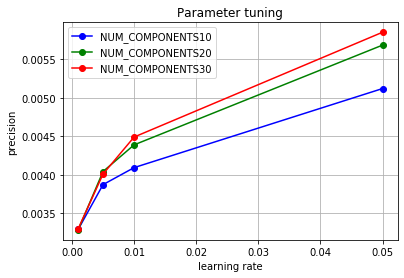


The best model has 30 NUM_COMPONENTS and learning_rate = 0.05


In [15]:
NUM_COMPONENTS = [10,20,30]    
NUM_EPOCHS = 25
learning_rate=[0.05,0.01,0.005,0.001]
# Let's fit a WARP model
colors=['b', 'g', 'r', 'c', 'm', 'y',]
prec = 0.0
best_model = None
best_learning_rate = 0.0
best_NUM_COMPONENTS = 0.0
auc1=[]
for a,i in enumerate(NUM_COMPONENTS):
  precision=[]
  for j in learning_rate:
    
    auc=[]
    model = LightFM(loss='warp',random_state=123,
                  no_components=i,
                  learning_rate=j)

    #  time it.
    #print("For learning rate %s num_component %s " %i %j)
    %time model = model.fit(trainin,epochs=NUM_EPOCHS)

    # Compute and print the AUC score
    #train_auc = auc_score(model, trainin).mean()
    #print('Collaborative filtering train AUC: %s' % train_auc)



    #test_auc = auc_score(model, testin).mean()
    #print('Collaborative filtering test AUC: %s' % test_auc)


    #print("Train precision: %.4f" % precision_at_k(model, trainin, k=k).mean())
    print('for no_comp ',i,'lr ',j)
    print("Test precision: %.4f" % precision_at_k(model, testin,train_interactions=trainin, k=k).mean())
    print("Test AUC: %.4f" % auc_score(model, testin).mean())
    precision.append(precision_at_k(model, testin,train_interactions=trainin, k=k).mean())
    if prec<precision_at_k(model, testin,train_interactions=trainin, k=k).mean():
      prec=precision_at_k(model, testin,train_interactions=trainin, k=k).mean()
      best_learning_rate=j
      best_NUM_COMPONENTS=i
      best_model=model
    
  plt.plot(learning_rate, precision,marker='o',color=colors[a],label='NUM_COMPONENTS'+str(i))
plt.xlabel('learning rate')
plt.ylabel('precision')
plt.title('Parameter tuning')
plt.grid(True)
plt.legend()
plt.show()
print('\nThe best model has {} NUM_COMPONENTS and learning_rate = {}'.format(best_NUM_COMPONENTS, best_learning_rate))


In [0]:
model = LightFM(loss='warp',random_state=123,
              no_components=30,
              learning_rate=0.05)
model = model.fit(trainin,epochs=25)


In [0]:
a=model.predict(testin.row,testin.col)

Recommendation score for each user in the test data was predicted 

In [18]:
(testin.row,a)

(array([    0,     1,     2, ..., 66965, 66966, 66967], dtype=int32),
 array([-0.23978022, -0.81041664,  2.21139407, ...,  2.32031608,
        -0.09479146,  2.30020213]))

Running model with user item features

CPU times: user 4min 45s, sys: 25.3 ms, total: 4min 45s
Wall time: 4min 45s
for no_comp  10 lr  0.05
Test precision: 0.0427
CPU times: user 4min 46s, sys: 22 ms, total: 4min 46s
Wall time: 4min 46s
for no_comp  10 lr  0.01
Test precision: 0.0362
CPU times: user 4min 44s, sys: 11 ms, total: 4min 44s
Wall time: 4min 44s
for no_comp  10 lr  0.005
Test precision: 0.0361
CPU times: user 8min 40s, sys: 32 ms, total: 8min 40s
Wall time: 8min 41s
for no_comp  20 lr  0.05
Test precision: 0.0521
CPU times: user 9min 2s, sys: 23 ms, total: 9min 2s
Wall time: 9min 2s
for no_comp  20 lr  0.01
Test precision: 0.0361
CPU times: user 8min 57s, sys: 29 ms, total: 8min 57s
Wall time: 8min 57s
for no_comp  20 lr  0.005
Test precision: 0.0361
CPU times: user 12min 51s, sys: 50 ms, total: 12min 51s
Wall time: 12min 51s
for no_comp  30 lr  0.05
Test precision: 0.0548
CPU times: user 14min 40s, sys: 55 ms, total: 14min 40s
Wall time: 14min 40s
for no_comp  30 lr  0.01
Test precision: 0.0356
CPU times: user 1

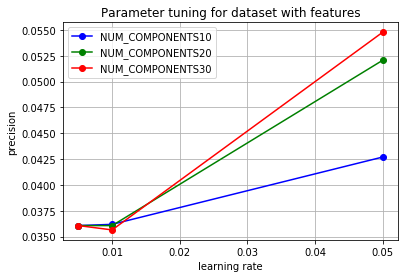


The best model has 30 NUM_COMPONENTS and learning_rate = 0.05


In [19]:
NUM_COMPONENTS = [10,20,30]    
NUM_EPOCHS = 25
learning_rate=[0.05,0.01,0.005]
# Let's fit a WARP model
colors=['b', 'g', 'r', 'c', 'm', 'y']
prec = 0
best_model = None
best_learning_rate = 0
best_NUM_COMPONENTS = 0
for a,i in enumerate(NUM_COMPONENTS):
  precision=[]
  for j in learning_rate:

    model.iii = LightFM(loss='warp',
                  random_state=123,
                no_components=i,learning_rate=j)

  #time it.
    #print("For learning rate ",i)
    %time model.iii = model.iii.fit(trainin,user_features=user_features,item_features=item_features,epochs=NUM_EPOCHS)
    pred=precision_at_k(model.iii, trainin,item_features=item_features,user_features=user_features, k=k).mean()
    precision.append(pred)
    print('for no_comp ',i,'lr ',j)
    print("Test precision: %.4f" % pred)
    #print("Test AUC: %.4f" % auc_score(model.iii, testin,user_features=user_features,item_features=item_features).mean())
    if prec<pred:
      prec=pred
      best_learning_rate=j
      best_NUM_COMPONENTS=i
      best_model=model.iii
    
  plt.plot(learning_rate, precision,marker='o',color=colors[a],label='NUM_COMPONENTS'+str(i))
plt.xlabel('learning rate')
plt.ylabel('precision')
plt.title('Parameter tuning for dataset with features')
plt.grid(True)
plt.legend()
plt.show()
print('\nThe best model has {} NUM_COMPONENTS and learning_rate = {}'.format(best_NUM_COMPONENTS, best_learning_rate))



  # Compute and print the AUC score
  #train_auc = auc_score(model.iii, trainin,user_features=user_features,item_features=item_features).mean()
  #print('Hybrid train AUC: %s' % train_auc)

  #test_auc = auc_score(model.iii, testin,user_features=user_features,item_features=item_features).mean()
  #print('Hybrid test AUC: %s' % test_auc)

  #precision @k
  #print("Train precision: %.4f" % precision_at_k(model.iii, trainin,
                                                #item_features=item_features,user_features=user_features, k=k).mean())
  #print("Test precision: %.4f" % precision_at_k(model.iii, testin,train_interactions=trainin,
                                                #item_features=item_features,user_features=user_features, k=k).mean())


Recommendation score for each user in the test data was predicted

In [25]:
a=best_model.predict(testin.row,testin.col)
(testin.row,a)

(array([    0,     1,     2, ..., 66965, 66966, 66967], dtype=int32),
 array([-1.34378839,  1.86549497, -0.46021515, ...,  2.09294581,
        -0.52674299,  0.36686608]))

In [26]:
auc_score(best_model, testin,user_features=user_features,item_features=item_features).mean()

0.88881236